In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.classification import *
from pyspark.ml.feature import HashingTF,Tokenizer, StopWordsRemover
import pandas as pd
import matplotlib.pyplot as plt
import session_info
session_info.show()

### Initialisation du projet *SPARK*

In [2]:
file = "../data/movie.csv"
appName="Sentiment analysis in Spark"
spark=SparkSession.builder.appName(appName).config("spark.some.config.option","some-value").getOrCreate()

### Lecture du *DATASET*

In [3]:
data=spark.read.csv(file,inferSchema=True,header=True,mode="DROPMALFORMED").select("text",col("label").cast("Int").alias("label"))
data.show(truncate=False,n=3)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Division de DATASET en données pour le traning et en données de Test

In [4]:
dividedData=data.randomSplit([0.7,0.3])
trainingData=dividedData[0]
testingData=dividedData[1]
train_rows=trainingData.count()
test_rows=testingData.count()
print("Training Data Rows:",train_rows,"; Testing Data rows:",test_rows)

Training Data Rows: 16080 ; Testing Data rows: 6843


### Affichage d'un graphe pour montrer la fréquence des données divisées

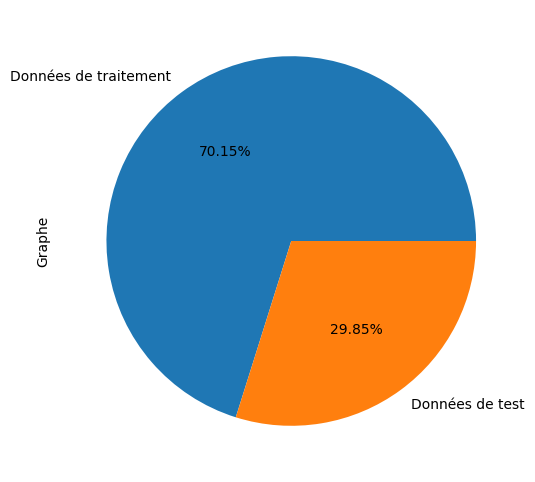

In [5]:
series = pd.Series([train_rows, test_rows], index=["Données de traitement", "Données de test"], name="Graphe")
series.plot.pie(autopct="%.2f%%", figsize=(6, 6));

### Découpage du texte en des tokens

In [6]:
tokenizer=Tokenizer(inputCol="text",outputCol="ReviewWords")
tokenizedTrain=tokenizer.transform(trainingData)
tokenizedTrain.show(truncate=False,n=5)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Ignorer Les "stop word"

In [7]:
swr=StopWordsRemover(inputCol=tokenizer.getOutputCol(),outputCol="MeaningfulWords")
SwRemovedTrain=swr.transform(tokenizedTrain)
SwRemovedTrain.show(truncate=False,n=5)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Représenter les mots d'un texte sous forme de vecteurs numériques

In [8]:
hashTF=HashingTF(inputCol=swr.getOutputCol(),outputCol="features")
numericTrainData=hashTF.transform(SwRemovedTrain).select('label','MeaningfulWords','features').na.drop(how='any')
numericTrainData.show(truncate=False,n=3)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Classification

In [9]:
lr=LogisticRegression(labelCol="label",featuresCol="features",maxIter=10,regParam=0.01)
model=lr.fit(numericTrainData)
print('Training is done')

Training is done


### Testing

In [10]:
tokenizedTest = tokenizer.transform(testingData)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest).select("label","Meaningfulwords","features").na.drop(how='any')
numericTest.show(truncate=False,n=5)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
prediction=model.transform(numericTest)
predictionFinal=prediction.select("MeaningfulWords","prediction","label")
predictionFinal.show(n=4,truncate=False)
correctPrediction = predictionFinal.filter(predictionFinal['prediction']==predictionFinal['label']).count()
totalData=predictionFinal.count()

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
print("Correct prediction:", correctPrediction," , total data:", totalData,", accuracy: ",correctPrediction/totalData)

Correct prediction: 5828  , total data: 6843 , accuracy:  0.8516732427297968


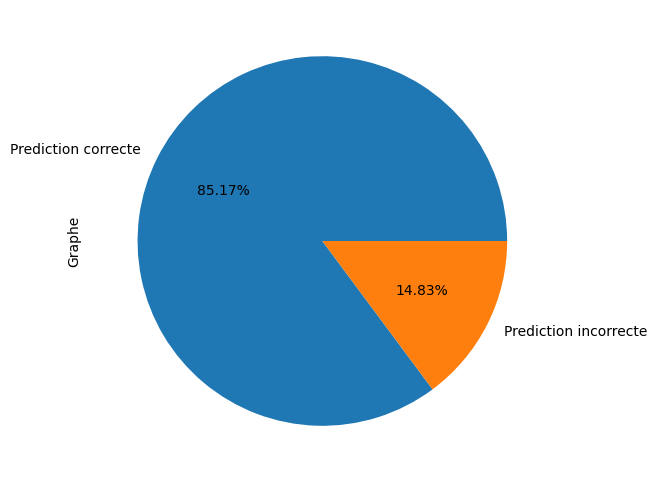

In [13]:
series = pd.Series([correctPrediction, totalData-correctPrediction], index=["Prediction correcte", "Prediction incorrecte"], name="Graphe")
series.plot.pie(autopct="%.2f%%", figsize=(6, 6));